In [1]:

%load_ext autoreload
%autoreload 2


In [2]:

import os; os.chdir(f'{os.getenv("MT_ROOT")}/src'); os.getcwd()
import matplotlib.pyplot as plt
import dataclasses as dc
import torch as th
import numpy as np

from jobs.specs.__100 import aetarn_smth_100 as tarn_opts
from jobs.specs.__100 import aei3d_smth_100 as i3d_opts
from models.ae_tarn import AETimeAlignedResNet
from models.ae_i3d import AEI3D
from pipeline.smth.databunch import SmthDataBunch
from models.engine import prepare_batch
import constants as ct


In [34]:
def pic_show(_video, model):
    num = len(_video)
    fig = plt.figure(figsize=(16, 32), dpi=80)
    for i in range(1,num+1):
        sub = fig.add_subplot(1,num,i)
        sub.set_title(str(i))
        sub.axis('off')
        sub.imshow(_video[i-1])
    # plt.show()
    plt.savefig(f'{os.getenv("MT_ROOT")}/src/exploration/model_inspection/ae_{model}_example.png', bbox_inches = 'tight', pad_inches = 0)

def un_normalize(_x):
    return _x * 255

def un_standardize(_x):
    means = th.tensor(ct.IMAGE_NET_MEANS).reshape((1, 3, 1, 1))
    stds = th.tensor(ct.IMAGE_NET_STDS).reshape((1, 3, 1, 1))
    
    return _x * stds + means

In [35]:
tarn_opts.trainer_opts.optimizer_opts.lr = 0.001
tarn_opts.valid_dl_opts.batch_size = 1
tarn_opts.dev_dl_opts.batch_size = 1
tarn_opts.trainer_opts.criterion_opts.mse_factor = 1.0
tarn_opts.trainer_opts.criterion_opts.ce_factor = 1.0
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

tarn_model = AETimeAlignedResNet(**dc.asdict(tarn_opts.model_opts)).to(device)
bunch = SmthDataBunch(tarn_opts.db_opts, tarn_opts.train_ds_opts, tarn_opts.dev_ds_opts, tarn_opts.valid_ds_opts, 
                      tarn_opts.train_dl_opts, tarn_opts.dev_dl_opts, tarn_opts.valid_dl_opts)
tarn_model.load_state_dict(th.load('../runs/dummy/smth/__100/aetarn_smth_100/best_model_31_loss=1.9097.pth', map_location=device))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [41]:

i3d_opts.trainer_opts.optimizer_opts.lr = 0.001
i3d_opts.valid_dl_opts.batch_size = 1
i3d_opts.dev_dl_opts.batch_size = 1
i3d_opts.trainer_opts.criterion_opts.mse_factor = 1.0
i3d_opts.trainer_opts.criterion_opts.ce_factor = 1.0
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

i3d_model = AEI3D(**dc.asdict(i3d_opts.model_opts)).to(device)
bunch = SmthDataBunch(i3d_opts.db_opts, i3d_opts.train_ds_opts, i3d_opts.dev_ds_opts, i3d_opts.valid_ds_opts, 
                      i3d_opts.train_dl_opts, i3d_opts.dev_dl_opts, i3d_opts.valid_dl_opts)

i3d_model.load_state_dict(th.load('../runs/dummy/smth/__100/aei3d_smth_100/best_model_37_loss=2.1093.pth', map_location=device))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:

batch = next(iter(bunch.valid_loader))
video, label = bunch.valid_set[0]
x, y = prepare_batch(batch, device, False)


In [43]:

video, label


(Video 172305 (4x3x224x224), (6 Throwing something))

In [44]:

# for epoch in range(300):
#     model.train()
#     optimizer.zero_grad()
#     _pred, _embed, _recon = model(x, inference=False)
#     mse, ce = loss_fn(_recon, _pred.reshape(1, 30), x, y)
#     (mse + ce).backward()
#     print(f'EPOCH={epoch:03d} | CE={ce:.4f} | MSE={mse:.4f}')
#     optimizer.step()


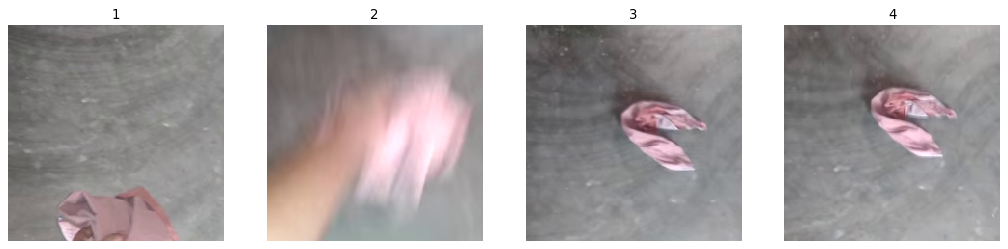

In [38]:

_in = video.data.astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_in, 'data')


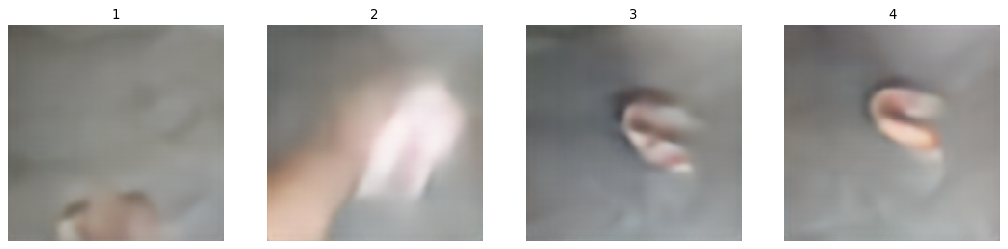

In [39]:

tarn_model.eval()
_pred, _embed, _recon = tarn_model(x, inference=True)

_rec = un_normalize(un_standardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_rec, 'tarn')


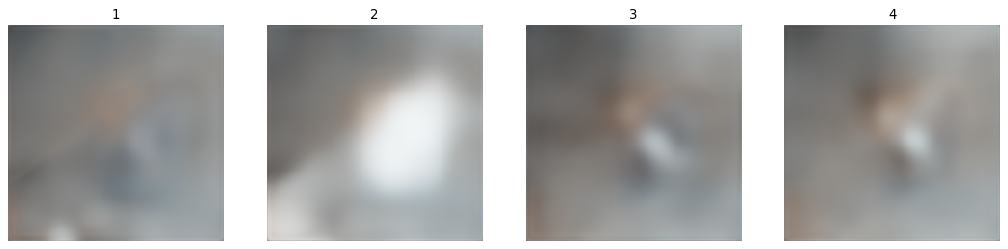

In [45]:

i3d_model.eval()
_pred, _embed, _recon = i3d_model(x, inference=True)

_rec = un_normalize(un_standardize(_recon.detach().cpu()))
_rec = _rec.numpy().reshape(4, 3, 224, 224).astype(np.int).swapaxes(1,2).swapaxes(2,3)
pic_show(_rec, 'i3d')
